# Multivariate analysis

Interpret all of the plate kinematic and rheological information within a statistical framework.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sn
import gplately
%matplotlib inline

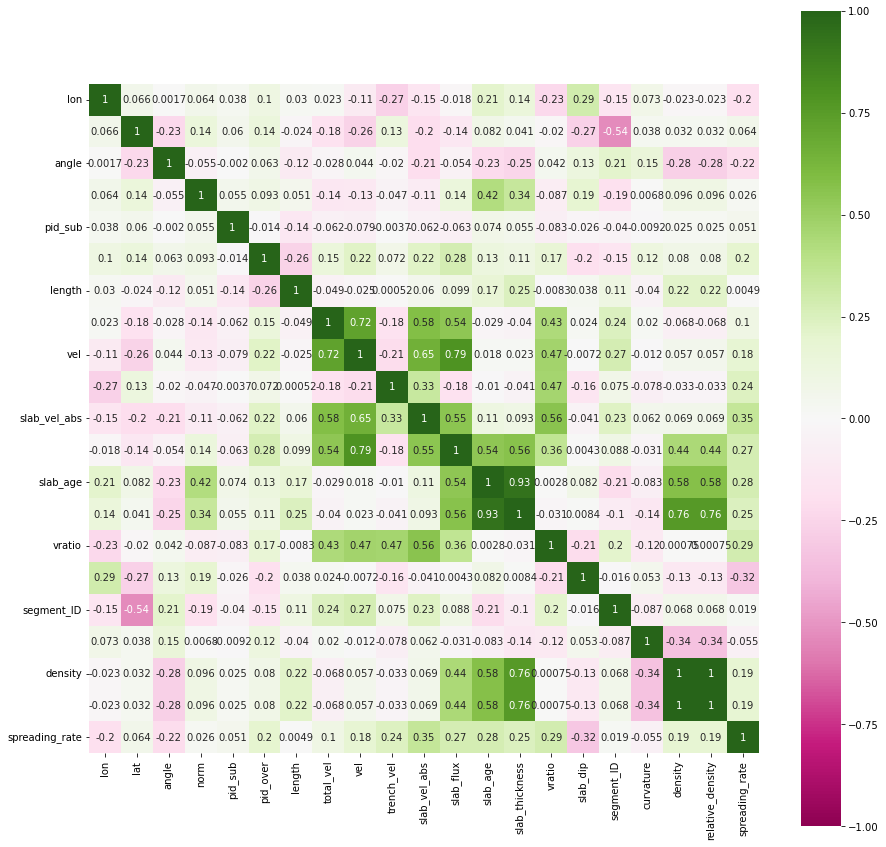

In [2]:
df = pd.read_csv("data/subduction_data.csv", index_col=0)

# remove ultra slow convergence velocities
# df = df[df['vel'] > 0.01]

# remove NaN entries
df = df[np.isfinite(df['slab_dip'])]

# remove europe
df = df[np.logical_or(df['lon'] > 70, df['lon'] < -20)]

# Plot a Pearson correlation coefficient matrix
sn.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap='PiYG', square=True)
fig = plt.gcf()
fig.set_size_inches(15, 15)

In [3]:
df_stats = df.describe()
df_stats

,lon,lat,angle,norm,pid_sub,pid_over,length,total_vel,vel,trench_vel,...,slab_flux,slab_age,slab_thickness,vratio,slab_dip,segment_ID,curvature,density,relative_density,spreading_rate
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,...,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,26.797571,5.370481,1.079236,168.130729,1395.059898,45776.228426,42901.369037,0.062836,0.056395,-0.019004,...,3860.906040,57.845972,68140.059127,0.627925,35.757275,27.052792,0.000019,3277.811288,-22.188712,0.043608
std,126.748963,28.212391,37.147780,121.222945,13535.803279,136375.797183,11188.126500,0.042734,0.029829,0.018208,...,2579.861787,42.892208,26203.457273,0.318327,11.924971,13.593969,0.000262,60.910271,60.910271,0.024506
min,-179.937538,-60.675510,-115.345592,1.451468,101.000000,101.000000,774.618472,-0.134422,0.000000,-0.104441,...,0.000000,0.000000,0.000000,0.000000,2.997555,0.000000,-0.000655,2900.000000,-400.000000,0.000590
25%,-81.753494,-11.274134,-21.886759,54.641320,697.000000,413.000000,37518.476106,0.047641,0.036355,-0.021523,...,1441.353982,23.510889,49949.169159,0.420039,28.626449,15.000000,-0.000029,3269.738739,-30.261261,0.025817
50%,102.959602,1.722252,0.903939,125.831280,901.000000,697.000000,46510.399853,0.067745,0.056897,-0.014448,...,3723.447557,44.942549,69033.861160,0.726093,36.401979,26.000000,-0.000002,3295.995654,-4.004346,0.040473
75%,142.000000,20.050005,21.327331,291.688230,903.000000,847.000000,50906.461213,0.090895,0.076585,-0.007068,...,5823.531834,95.577198,94698.905945,0.892117,43.469563,38.000000,0.000035,3311.341382,11.341382,0.057898
max,179.426407,60.451013,108.719837,359.685144,301300.000000,601131.000000,55597.541862,0.168125,0.145023,-0.000014,...,12253.404369,153.097290,102871.179581,1.000000,71.382011,48.000000,0.003373,3313.887381,13.887381,0.167724


## Regression and machine learning

We use the regression and machine learning routines in [scikit-learn](https://scikit-learn.org) (`sklearn`) to infer slab dip from plate kinematics and rheology. To do this, we train the model (linear model, neural network, etc.) on a matrix $X_{t=0}$, which contains our training data, to predict our result $y_{t=0}$, which is the slab dip for the present day.

Depending on how well the model can reproduce the slab dip at the present day, we can apply the same model to predict the slab dip back through geological time by feeding the input variables reconstructed to different geological times $X_{t=1,2,\ldots,k}$.

First, we subset the data for variables which show promise of predicting slab dip. These can be added or removed to improve the predction.

In [4]:
variable_names = ['angle', 'vel', 'trench_vel', 'vratio', 'slab_age', 'slab_thickness',
                  'spreading_rate', 'density', 'curvature']

df_X_train = df[variable_names]
df_y_train = df['slab_dip']

In [5]:
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, NuSVR

In [6]:
fs = feature_selection.SelectKBest(feature_selection.f_regression, k='all')
transform = fs.fit_transform(df_X_train, df_y_train)

(0.0, 109.1372209091832)

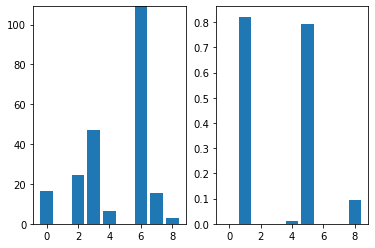

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.bar(range(fs.n_features_in_), fs.scores_)
ax2.bar(range(fs.n_features_in_), fs.pvalues_)

ax1.set_ylim(0, max(fs.scores_))

### Linear regression

In [8]:
# rescale the input vector
scaler = preprocessing.StandardScaler()
scaler.fit(df_X_train)
X_train = scaler.transform(df_X_train)
y_train = df_y_train.values

# fit the model to the data
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print("R2 value = {:.2f}".format(regr.score(X_train,y_train)))

# predict y given the same X
y_pred = regr.predict(X_train)

R2 value = 0.22


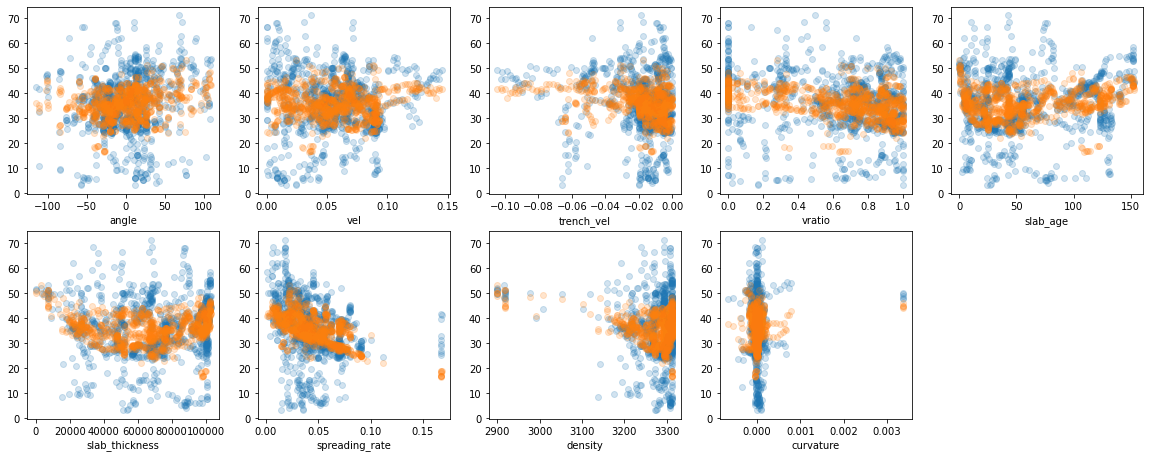

In [9]:
fig = plt.figure(figsize=(20,20))

gs = GridSpec(5,5)

for i, variable_name in enumerate(variable_names):
    ax = fig.add_subplot(gs[i], xlabel=variable_name)
    ax.scatter(df_X_train[variable_name], df_y_train, alpha=0.2)
    ax.scatter(df_X_train[variable_name], y_pred, alpha=0.2)
    

Simple linear regression works OK, but with an $R^2$ value of just 0.22 we can do better.

### Support Vector Regression (SVR)

Using a polynomial fitting kernel.

R2 value = 0.29


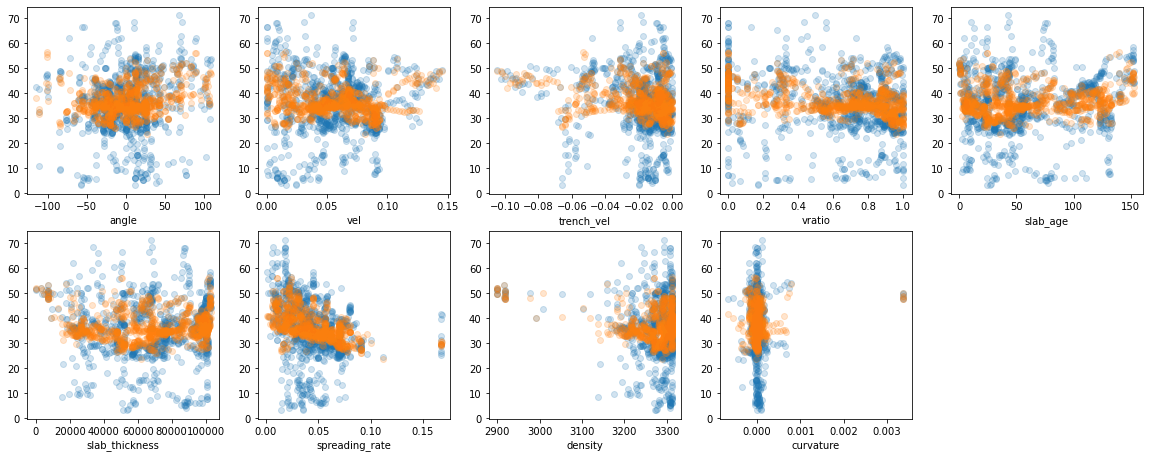

In [10]:
svr = SVR(kernel='poly', degree=3)
svr.fit(X_train, df_y_train.values)

print("R2 value = {:.2f}".format(svr.score(X_train, df_y_train.values)))

y_predict = svr.predict(X_train)


fig = plt.figure(figsize=(20,20))

gs = GridSpec(5,5)

for i, variable_name in enumerate(variable_names):
    ax = fig.add_subplot(gs[i], xlabel=variable_name)
    ax.scatter(df_X_train[variable_name], df_y_train, alpha=0.2)
    ax.scatter(df_X_train[variable_name], y_predict, alpha=0.2)

Getting better, but we can do better still...

### Machine learning

We use a multi-layer perceptron regressor (`MLPregressor`) which iteratively trains a neural network using the partial derivatives of the objective (or loss) function with respect to the parameters. We opt for the L-BFGS gradient descent solver for its efficiency and robustness as a Newton solver. It replaces the exact Hessian matrix with an approximation for computational efficiency.

In [11]:
scaler = preprocessing.StandardScaler()
scaler.fit(df_X_train)
X_train = scaler.transform(df_X_train)

# I had to increase the maximum number of iterations
mlp = MLPRegressor(solver='lbfgs', max_iter=2000, tol=0.05)
mlp.fit(X_train, df_y_train.values)

print("R2 value = {:.2f}".format(mlp.score(X_train, df_y_train.values)))

y_predict = mlp.predict(X_train)

R2 value = 0.98


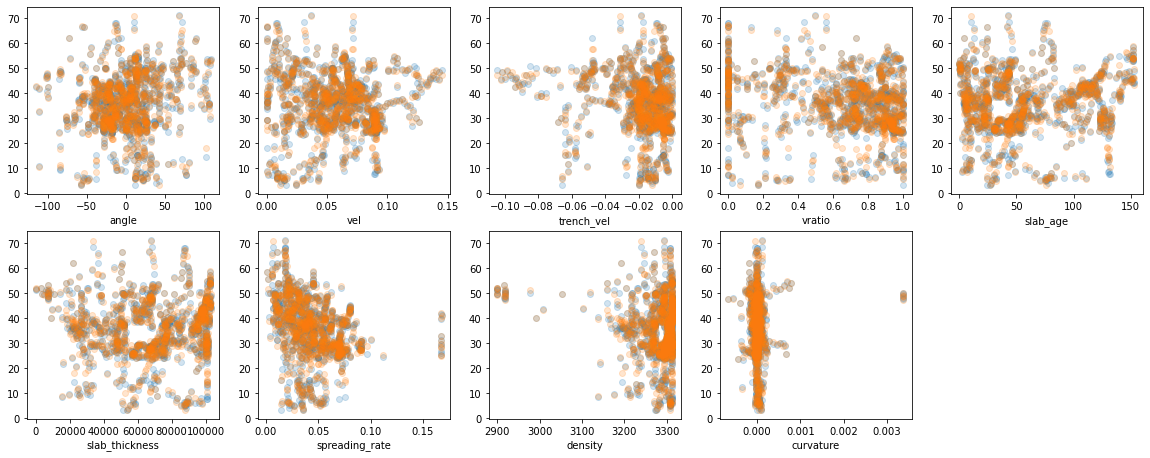

In [12]:
fig = plt.figure(figsize=(20,20))

gs = GridSpec(5,5)

for i, variable_name in enumerate(variable_names):
    ax = fig.add_subplot(gs[i], xlabel=variable_name)
    ax.scatter(df_X_train[variable_name], df_y_train, alpha=0.2)
    ax.scatter(df_X_train[variable_name], y_predict, alpha=0.2)

Wow! This has performed extremely well with an $R^2$ value of 0.98.

## Plot parameter relationships

It is helpful to delineate individual subduction zones from the entire cloud of points. We use the segment IDs of each point to plot the median and standard deviation for subduction zone segments.

In [13]:
def plot_segments(segment_IDs, var1, var2):
    
    v1, label1 = tuple(var1)
    v2, label2 = tuple(var2)
    
    fig = plt.figure(figsize=(10,4))
    
    ax1 = fig.add_subplot(121, xlabel=label1, ylabel=label2)
    sc1 = ax1.scatter(v1, v2, alpha=0.25)
    
    ax2 = fig.add_subplot(122, xlabel=label1, ylabel=label2)
    
    unique_segment_IDs, ncounts = np.unique(segment_IDs, return_counts=True)
    unique_segment_IDs = unique_segment_IDs[ncounts > 1]
    
    for index, segID in enumerate(unique_segment_IDs):
        mask_segment = segment_IDs == segID

        ax2.errorbar(np.nanmedian(v1[mask_segment]), np.nanmedian(v2[mask_segment]),
                     xerr=np.nanstd(v1[mask_segment]), yerr=np.nanstd(v2[mask_segment]),
                     fmt='o', capsize=3)

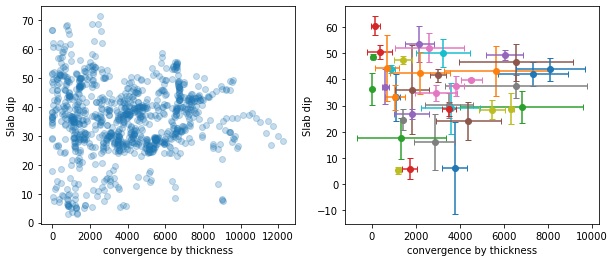

In [14]:
plot_segments(df['segment_ID'],
             (df['slab_thickness']*df['vel'], 'convergence by thickness'),
             (df['slab_dip'], 'Slab dip'))

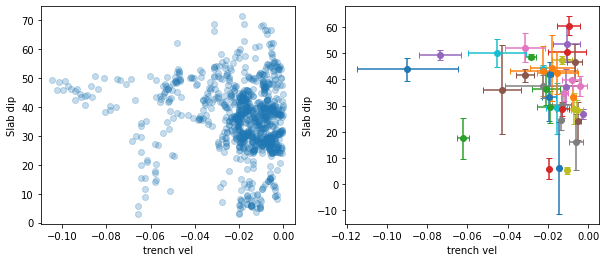

In [15]:
plot_segments(df['segment_ID'],
             (df['trench_vel'], 'trench vel'),
             (df['slab_dip'], 'Slab dip'))

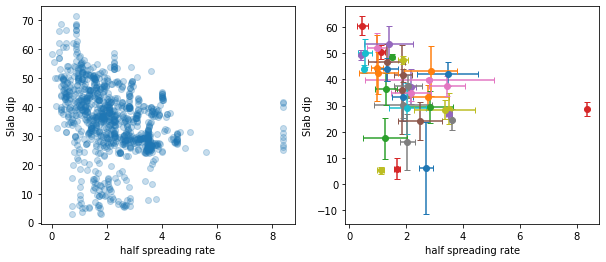

In [16]:
plot_segments(df['segment_ID'],
             (0.5*df['spreading_rate']*100, 'half spreading rate'),
             (df['slab_dip'], 'Slab dip'))

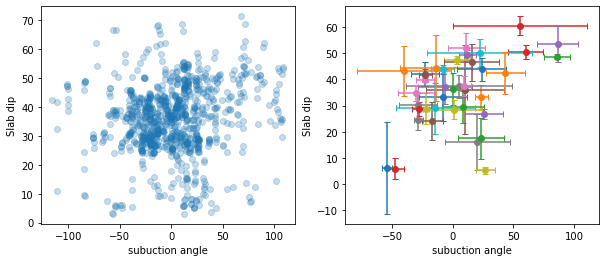

In [17]:
plot_segments(df['segment_ID'],
             (df['angle'], 'subuction angle'),
             (df['slab_dip'], 'Slab dip'))

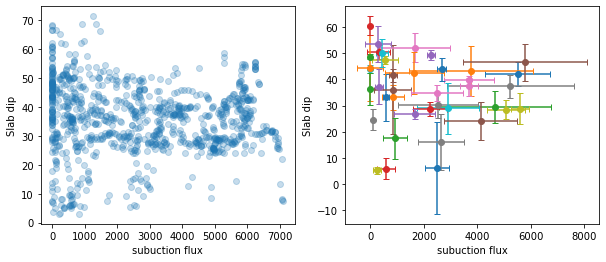

In [18]:
vratio = (df['vel'] + df['trench_vel'])/(df['vel'] + 1e-22)
vratio[df['slab_vel_abs'] < 0] *= -1
vratio = np.clip(vratio, 0, 1)



plot_segments(df['segment_ID'],
             ((df['vel']*vratio)*df['slab_thickness'], 'subuction flux'),
             (df['slab_dip'], 'Slab dip'))

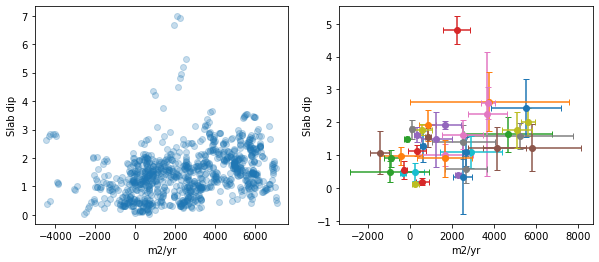

In [19]:
plot_segments(df['segment_ID'],
             ((df['slab_thickness']*(df['vel']+df['trench_vel'])), 'm2/yr'),
             (df['slab_dip']*df['spreading_rate'], 'Slab dip'))

## Save summary statistics for each subduction zone

Save to a csv file

In [20]:
unique_segment_IDs = np.unique(df['segment_ID'])

empty_data = np.zeros((len(unique_segment_IDs), len(df.columns)))

# initialise empty data frames
df_segments = pd.DataFrame(data=empty_data, columns=df.columns)
df_segments_std = pd.DataFrame(data=empty_data.copy(), columns=df.columns)

length_ratio = np.zeros(len(unique_segment_IDs))

for i, seg_ID in enumerate(unique_segment_IDs):
    mask_segment = df['segment_ID'] == seg_ID
    
    for column in df:
        # take the median
        df_segments[column][i] = np.nanmedian(df[column][mask_segment])
        df_segments_std[column][i] = np.nanstd(df[column][mask_segment])
        
    # some variables require summing
    df_segments['length'][i] = np.nansum(df['length'][mask_segment])
    
    xs, ys, zs = gplately.tools.lonlat2xyz(df['lon'], df['lat'])
    xyz = np.c_[xs,ys,zs]
    
    # distance as the bird flies from start to end of trench
    dist_bird = np.linalg.norm(xyz[-1] - xyz[0])
    
    # divide this by the total length
    length_ratio[i] = dist_bird/df_segments['length'][i]

In [21]:
df_segments.to_csv('data/subduction_segments_data.csv')
df_segments_std.to_csv('data/subduction_segments_data_std.csv')